# Set Up the meta 

In [1]:
from osgeo import ogr, osr

In [2]:
driver = ogr.GetDriverByName('ESRI Shapefile')

In [3]:
dataset = driver.Open("/home/smitesh22/Data/GIS Extracted/N19E072_wgs84/planet_72,19_73,20-shp/shape/", 0)

In [4]:
layer_types = {
              0:'places',
              1: 'railway',
              2:'landuse',
              3:'natural',
              4:'point',
              5:'waterway',
              6:'road',
              7:'buildings'}

In [5]:
layer_metadata = {}
for num in layer_types:
    layer = dataset.GetLayer(num)
    
    attributes = []
    for feature in layer:
        attributes.append(feature.items())
    meta = set()
    
    for attr in attributes:
        #print(attr['type'])
        meta.add(attr['type'])
        
        
    layer_metadata[layer_types[num]] = meta

In [6]:
layer_metadata.keys()

dict_keys(['places', 'railway', 'landuse', 'natural', 'point', 'waterway', 'road', 'buildings'])

### Create Plot

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [8]:
shapefile_path = "/home/smitesh22/Data/GIS Extracted/N19E072_wgs84/planet_72,19_73,20-shp/shape/points.shp"
gdf = gpd.read_file(shapefile_path)

In [9]:
gdf['type'].unique()

array(['switch', 'station', 'level_crossing', 'stop', 'traffic_signals',
       'hotel', 'clinic', 'crossing', 'school', 'parking',
       'mini_roundabout', 'bus_stop', 'hospital', 'restaurant',
       'place_of_worship', 'motorway_junctio', 'attraction', 'ruins',
       'studio', 'bank', 'theatre', 'fast_food', 'ice_cream', 'college',
       'pharmacy', 'cafe', 'police', 'The Wall', 'pub', 'toilets',
       'memorial', 'fuel', 'telephone', 'ferry_terminal', 'buffer_stop',
       'water_tower', 'hostel', 'post_box', 'bus_station', 'lighthouse',
       'atm', 'theme_park', 'fire_station', 'community_centre',
       'post_office', 'fountain', 'picnic_site', 'works', 'cinema',
       'marketplace', 'bar', 'monument', 'kindergarten', 'signal',
       'railway_crossing', 'car_wash', 'doctors', 'townhall', 'viewpoint',
       'clubhouse', 'guest_house', 'drinking_water', 'museum',
       'battlefield', 'library', 'taxi', 'turning_circle', 'artwork',
       'water_well', 'motel', 'fort', 'ch

In [10]:
gdf = gdf.to_crs("EPSG:3857")

In [11]:
#100 meters buffer
gdf['geometry'] = gdf['geometry'].buffer(100)

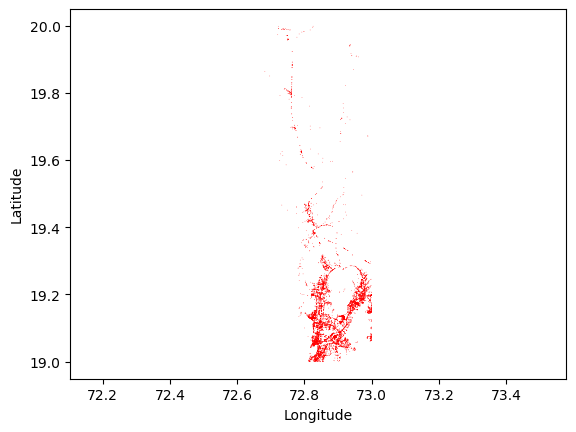

In [12]:
# Convert the GeoDataFrame to a geographic CRS if it's not already
# WGS 84 (EPSG:4326) is a common choice that uses degrees for latitude and longitude
gdf = gdf.to_crs(epsg=4326)

# Plot the data
gdf.plot(color='red')

# Add labels for clarity
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Ensure that the axes are equally scaled
plt.axis('equal')

# Show the plot
plt.show()

In [13]:
gdf

osm_id  timestamp          name              type  \
0        30518270        NaN           NaN            switch   
1        30518283        NaN    Vasai Road           station   
2        30518292        NaN       Naigaon           station   
3        30518297        NaN     Bhayandar           station   
4        30518361        NaN      Kharbhav           station   
...           ...        ...           ...               ...   
11339 -1852816091        NaN       Riwayat        restaurant   
11340 -1851005530        NaN           NaN  railway_crossing   
11341 -1850993664        NaN           NaN            switch   
11342 -1850993660        NaN           NaN            switch   
11343 -1849575532        NaN  Radisson Blu             hotel   

                                                geometry  
0      POLYGON ((72.85382 19.30654, 72.85382 19.30645...  
1      POLYGON ((72.83292 19.38267, 72.83292 19.38258...  
2      POLYGON ((72.84774 19.35049, 72.84774 19.35041...  
3      POLYGON ((72.85400 19.31027, 72.85399 19.31019...  
4      POLYGON ((72.98537 19.29832, 72.98536 19.29824...  
...                                                  ...  
11339  POLYGON ((72.81467 19.13483, 72.81467 19.13475...  
11340  POLYGON ((72.82950 19.19736, 72.82949 19.19727...  
11341  POLYGON ((72.82969 19.19720, 72.82969 19.19712...  
11342  POLYGON ((72.82927 19.19753, 72.82927 19.19745...  
11343  POLYGON ((72.87966 19.11019, 72.87966 19.11011...  

[11344 rows x 5 columns]

In [14]:
import re
import pandas as pd
import glob

def get_suitable_area(shapefile_path, buffer):
    """
    params : shapefile_path : location where shp files for the geolocations are present
             buffer : buffer distance in meters
    
    output : Geodataframe with features needed to be considered along with a buffer of 100 meters
    
    """
    
    gdfs = []
    
    #shapefile_path = "/home/smitesh22/Data/GIS Extracted/N19E072_wgs84/planet_72,19_73,20-shp/shape/landuse.shp"
    
    #get all the shapefiles available for the geolocation
    shape_files = glob.glob(f'{shapefile_path}*.shp')
    #print(shape_files)
    #loop over each shape file
    for shape_file in shape_files:
        
        match = re.search(r'([^/]+)\.shp$', shape_file)
        #feature to identiy layer
        feature = match.group(1)
        
        #print(shape_file)
        gdf = gpd.read_file(shape_file)
        
        #EPSG:3395 (World Mercator) uses metric system
        gdf = gdf.to_crs(epsg=3395)
        
        #add a buffer of 100 meters
        gdf['geometry'] = gdf['geometry'].buffer(buffer)
        
        #conditions on each layer to select CERTAIN attribute values only
        if feature == "places":
            pass
        elif feature == "landuse":
            filtered_gdf = gdf[~gdf['type'].isin(['vacant', 'barren'])]
        elif feature == "natural":
            pass
        
        filtered_gdf = gdf
        
        filtered_gdf['feature'] = feature
        
        gdfs.append(filtered_gdf)
        
        # Concatenate all the GeoDataFrames in the list
    combined_gdf = pd.concat(gdfs, ignore_index=True)
        
        #print(combined_gdf)
    return combined_gdf

In [15]:
combined_gdf = get_suitable_area("/home/smitesh22/Data/GIS Extracted/N09E078_wgs84/planet_78,9_79,10-shp/shape/", 1000)

In [16]:
combined_gdf

osm_id            name     type  population  \
0       245582627      Sevalpatti  village         NaN   
1       245582675    Vilattikulam     town         NaN   
2       245583689     Sethu Karai  village         NaN   
3       245583770           Pudur  village         NaN   
4       245583830  Agastiarkuttam  village         NaN   
...           ...             ...      ...         ...   
68955  1181465690             NaN      NaN         NaN   
68956  1185073614             NaN      NaN         NaN   
68957  1185073615             NaN      NaN         NaN   
68958  1185073616             NaN      NaN         NaN   
68959  1185073617             NaN      NaN         NaN   

                                                geometry    feature  \
0      POLYGON ((8722588.490 1014067.788, 8722586.082...     places   
1      POLYGON ((8702045.814 1014004.143, 8702043.406...     places   
2      POLYGON ((8777278.754 1027237.301, 8777276.346...     places   
3      POLYGON ((8698531.435 1032313.763, 8698529.028...     places   
4      POLYGON ((8794276.105 1033358.109, 8794273.697...     places   
...                                                  ...        ...   
68955  POLYGON ((8698844.660 1100350.445, 8698867.571...  buildings   
68956  POLYGON ((8699867.171 1101417.707, 8699862.417...  buildings   
68957  POLYGON ((8699394.106 1101892.846, 8699442.835...  buildings   
68958  POLYGON ((8699434.131 1101891.428, 8699438.840...  buildings   
68959  POLYGON ((8699390.468 1100940.308, 8699341.661...  buildings   

       timestamp  width  ref  oneway  bridge  maxspeed  
0            NaN    NaN  NaN     NaN     NaN       NaN  
1            NaN    NaN  NaN     NaN     NaN       NaN  
2            NaN    NaN  NaN     NaN     NaN       NaN  
3            NaN    NaN  NaN     NaN     NaN       NaN  
4            NaN    NaN  NaN     NaN     NaN       NaN  
...          ...    ...  ...     ...     ...       ...  
68955        NaN    NaN  NaN     NaN     NaN       NaN  
68956        NaN    NaN  NaN     NaN     NaN       NaN  
68957        NaN    NaN  NaN     NaN     NaN       NaN  
68958        NaN    NaN  NaN     NaN     NaN       NaN  
68959        NaN    NaN  NaN     NaN     NaN       NaN  

[68960 rows x 12 columns]

In [17]:
# Calculate the total area
total_area = combined_gdf['geometry'].area.sum()

# Print the result
print(f"The total area is {total_area/1000} square units.")

The total area is 72110598.20120317 square units.


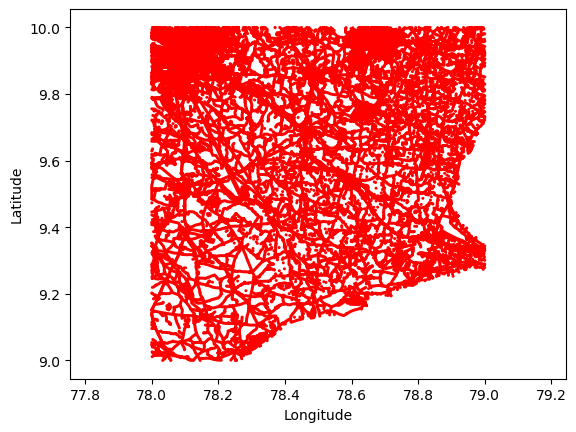

In [18]:
# Convert the GeoDataFrame to a geographic CRS if it's not already
# WGS 84 (EPSG:4326) is a common choice that uses degrees for latitude and longitude
combined_gdf = combined_gdf.to_crs(epsg=4326)

# Plot the data
combined_gdf.plot(color='red')

# Add labels for clarity
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Ensure that the axes are equally scaled
plt.axis('equal')

# Show the plot
plt.show()

In [19]:
def calculate_middle_coordinates(lat_ul, lon_ul, lat_lr, lon_lr):
    upper_middle = ((lat_ul + lat_lr) / 2, lon_ul)
    left_middle = (lat_ul, (lon_ul + lon_lr) / 2)
    right_middle = (lat_lr, (lon_ul + lon_lr) / 2)
    lower_middle = ((lat_ul + lat_lr) / 2, lon_lr)
    
    return upper_middle, left_middle, right_middle, lower_middle

# Example usage:
lat_ul = 16.0001388888888
lon_ul = 79.0001388888889
lat_lr = 14.9998611111111
lon_lr = 77.9998611111111



In [20]:
combined_gdf

osm_id            name     type  population  \
0       245582627      Sevalpatti  village         NaN   
1       245582675    Vilattikulam     town         NaN   
2       245583689     Sethu Karai  village         NaN   
3       245583770           Pudur  village         NaN   
4       245583830  Agastiarkuttam  village         NaN   
...           ...             ...      ...         ...   
68955  1181465690             NaN      NaN         NaN   
68956  1185073614             NaN      NaN         NaN   
68957  1185073615             NaN      NaN         NaN   
68958  1185073616             NaN      NaN         NaN   
68959  1185073617             NaN      NaN         NaN   

                                                geometry    feature  \
0      POLYGON ((78.35635 9.13150, 78.35632 9.13106, ...     places   
1      POLYGON ((78.17181 9.13093, 78.17179 9.13049, ...     places   
2      POLYGON ((78.84764 9.24905, 78.84761 9.24861, ...     places   
3      POLYGON ((78.14024 9.29435, 78.14022 9.29391, ...     places   
4      POLYGON ((79.00033 9.30367, 79.00030 9.30323, ...     places   
...                                                  ...        ...   
68955  POLYGON ((78.14305 9.90093, 78.14326 9.90131, ...  buildings   
68956  POLYGON ((78.15224 9.91043, 78.15219 9.91000, ...  buildings   
68957  POLYGON ((78.14799 9.91466, 78.14842 9.91462, ...  buildings   
68958  POLYGON ((78.14835 9.91465, 78.14839 9.91465, ...  buildings   
68959  POLYGON ((78.14795 9.90618, 78.14752 9.90622, ...  buildings   

       timestamp  width  ref  oneway  bridge  maxspeed  
0            NaN    NaN  NaN     NaN     NaN       NaN  
1            NaN    NaN  NaN     NaN     NaN       NaN  
2            NaN    NaN  NaN     NaN     NaN       NaN  
3            NaN    NaN  NaN     NaN     NaN       NaN  
4            NaN    NaN  NaN     NaN     NaN       NaN  
...          ...    ...  ...     ...     ...       ...  
68955        NaN    NaN  NaN     NaN     NaN       NaN  
68956        NaN    NaN  NaN     NaN     NaN       NaN  
68957        NaN    NaN  NaN     NaN     NaN       NaN  
68958        NaN    NaN  NaN     NaN     NaN       NaN  
68959        NaN    NaN  NaN     NaN     NaN       NaN  

[68960 rows x 12 columns]

In [21]:
import folium
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming `gdf` is your GeoPandas DataFrame with the polygons
# ...

ne_latitude = 10
ne_longitude = 79
sw_latitude = 9
sw_longitude = 78

# Calculate center latitude and longitude
center_latitude = (sw_latitude + ne_latitude) / 2
center_longitude = (sw_longitude + ne_latitude) / 2

# Create a folium map at the center
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=10)

# Highlight the defined area with a rectangle
folium.Rectangle(
    bounds=[(sw_latitude, sw_longitude), (ne_latitude, ne_longitude)],
    color="#ff7800",
    fill=True,
    fill_color="#ffff00",
    fill_opacity=0.2,
).add_to(m)

# Combine all polygons into one (if not already done)
combined_polygon = combined_gdf['geometry'].unary_union

# Plot the combined polygon on the map
folium.GeoJson(combined_polygon).add_to(m)

# Display the map in Jupyter or save to a file
m


In [22]:
import folium
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming `gdf` is your GeoPandas DataFrame with the polygons
# ...

ne_latitude = 10
ne_longitude = 79
sw_latitude = 9
sw_longitude = 78

# Calculate center latitude and longitude
center_latitude = (sw_latitude + ne_latitude) / 2
center_longitude = (sw_longitude + ne_latitude) / 2

# Create a folium map at the center
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=10)

# Highlight the defined area with a rectangle
folium.Rectangle(
    bounds=[(sw_latitude, sw_longitude), (ne_latitude, ne_longitude)],
    color="#ff7800",
    fill=True,
    fill_color="#ffff00",
    fill_opacity=0.2,
).add_to(m)

# Subtract the union of your existing polygons from the large polygon
complementary_geometry = combined_polygon.difference(combined_polygon)

# Plot the complementary geometry on the map
folium.GeoJson(complementary_geometry, 
               style_function=lambda x: {'fillColor': '#0000ff'}).add_to(m)

# Display the map in Jupyter or save to a file
m


In [23]:
from shapely.geometry import box

# Create a bounding box that covers the entire area you're interested in
# (You might need to customize this to suit your data)
bounds = combined_polygon.bounds
large_polygon = box(bounds[0] - 1, bounds[1] - 1, bounds[2] + 1, bounds[3] + 1)

# Subtract the union of your existing polygons from the large polygon
complementary_geometry = large_polygon.difference(combined_polygon)

# Plot the complementary geometry on the map
folium.GeoJson(complementary_geometry, 
               style_function=lambda x: {'fillColor': 'green',
                                        'fill': True,
                                        'fill_opacity': 1}).add_to(m)


In [24]:
m.save('map.html')